In [1]:
import numpy as np
import subprocess
import os
import glob
import yaml
import xarray as xr
import math
import matplotlib.pyplot as plt
import osprey_io as io
import osprey_means as osm 
import osprey_actions as osa

In [2]:
expname='ut05'
leg=11
yearspan=5
yearleap=10
data = io.read_restart(expname, leg)

In [3]:
#rdata = osa.forecast_T_rel(expname, leg, yearspan, yearleap)

In [32]:
# load data
df = osm.elements(expname)
startyear, endyear = io.start_end_years(expname, yearspan, leg)
data = io.readmf_T(expname, startyear, endyear)

# averaged variables
x = osm.dateDecimal(data['time'].values.flatten())
y = osm.movave(data['to'].weighted(df['vol']).mean(dim=['z', 'y', 'x']).values.flatten(),12)

# fit / forecast
xf = endyear+yearleap
mp,qp = osm.linear_fit(x, y)
yf = mp*xf + qp

# create new restart field using forecast
rdata = io.read_restart(expname, leg)
leg0 = int(leg)-int(yearspan)
rdata0 = io.read_restart(expname, leg0)
df['vol'] = df['vol'].rename({'z': 'nav_lev'})
varlist = ['tn', 'tb']
for var in varlist:
    tef = rdata[var].where(rdata[var]!=0.0).isel(time_counter=0).weighted(df['vol']).mean(dim=['nav_lev', 'y', 'x']).values
    trel = abs(yf-tef[0])
    dd = xr.where(rdata[var]!=0, rdata[var].values-rdata0[var].values, 0.0)
    rdata[var] = xr.where(dd>0, (1+abs(yf-rdata[var])/yf)*rdata[var], (1-abs(yf-rdata[var])/yf)*rdata[var])

In [33]:
dd = xr.where(rdata0['tn']!=0, rdata['tn'].values-rdata0['tn'].values, 0.0)

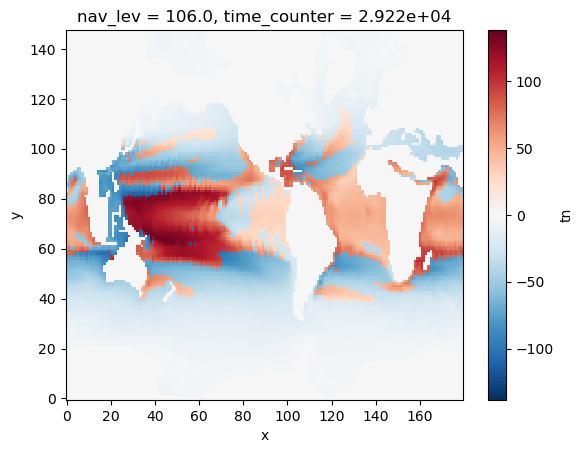

In [34]:
dd.isel(time_counter=0,nav_lev=10).plot()

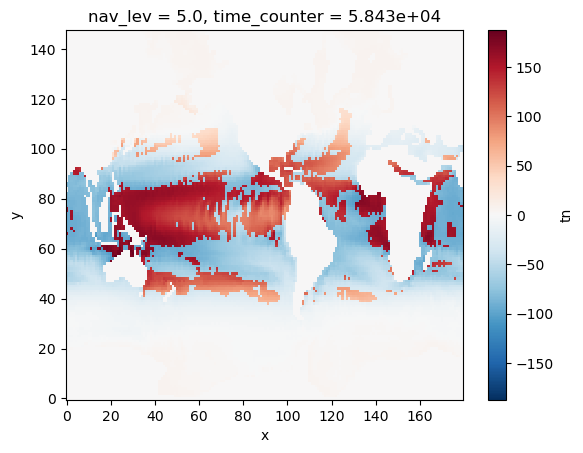

In [35]:
rdata['tn'].isel(time_counter=0,nav_lev=0).plot()

In [38]:
xx = osm.dateDecimal(data['time'].values.flatten())
yy = osm.movave(data['to'].weighted(df['vol']).mean(dim=['z', 'y', 'x']).values.flatten(),12)

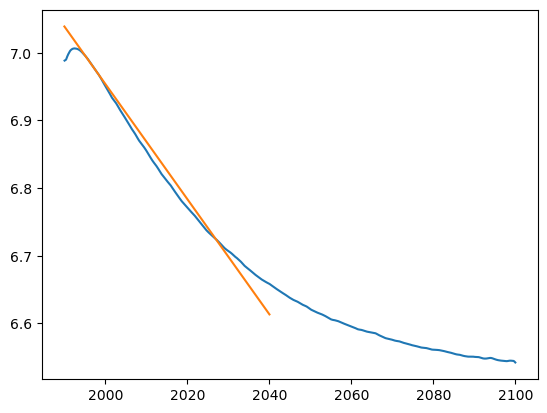

In [40]:
xa = [1990+i for i in range(51)]
ya = [mp*xa[i]+qp for i in range(len(xa))]
plt.plot(xx,yy)
plt.plot(xa,ya)